# BayesOPT Example for showing Gittins >> EIpu
Extension of the numerical examples presented in Theorem 1 of Raul and Peter's paper which aimed to show the limitation of EIpu and EI. This experiment extends the scope from Pandora's box (discrete finite points) to Bayesian optimization (continuous domain) and compares Gittins with EIpu/EI.

In [14]:
import torch
# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set default tensor type to float64
torch.set_default_dtype(torch.float64)

## Define the amplitude function and the cost function 
The continuous amplitude function and the continuous cost function are constructed based on the variances and costs of the discrete finite points provided in the original example

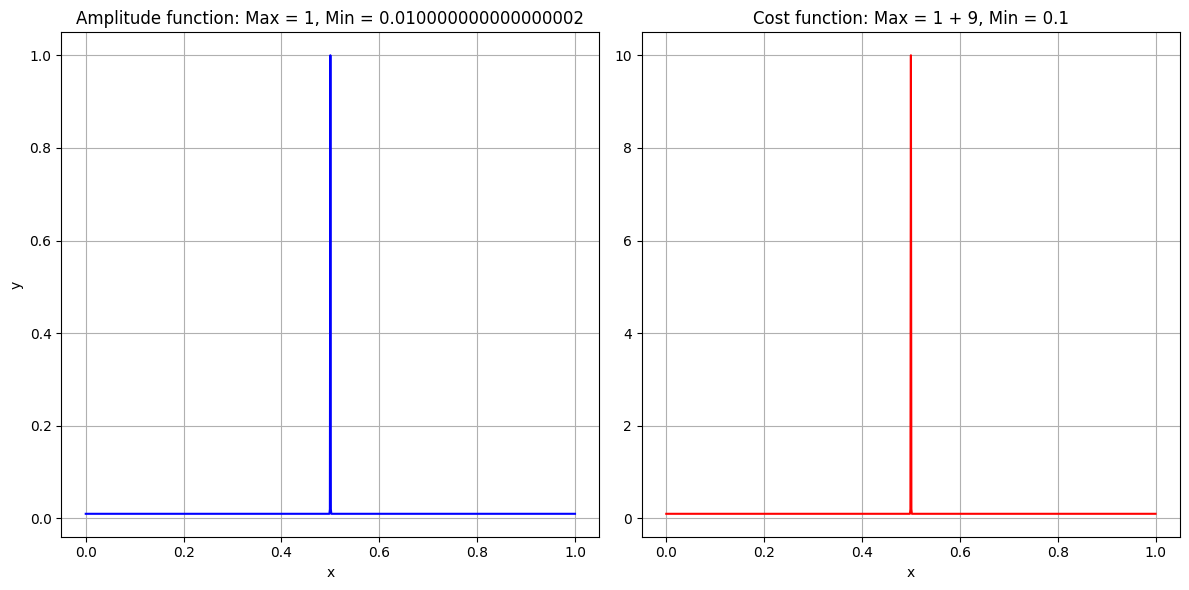

In [15]:
import matplotlib.pyplot as plt
import numpy as np
# Define typical small values for epsilon and delta, and a moderate value for K
epsilon = 0.1
delta = 9
amplitude_function_width = 0.002
cost_function_width = 0.002

# Define the functions for the amplitude and the cost
def amplitude_function(x):
    sigma = amplitude_function_width / (2*np.sqrt(-2 * np.log(epsilon**2)))  # Width of the bump to cover only the central point
    amplitude = torch.exp(-((x - 0.5)**2) / (2 * sigma**2)) * (1 - epsilon**2) + epsilon**2
    return amplitude.squeeze(-1)

def cost_function(x):
    sigma = cost_function_width / (2*np.sqrt(-2 * np.log(epsilon**2))) # Width of the bump to cover only the central point
    peak_height = 1 + delta - epsilon
    cost = torch.exp(-((x - 0.5)**2) / (2 * sigma**2)) * peak_height + epsilon
    return cost.squeeze(-1)

# Generate x values from 0 to 1
x_values = torch.linspace(0, 1, 1001)

# Generate y values for amplitude function and cost function
y_values_amplitude = amplitude_function(x_values)
y_values_cost = cost_function(x_values)

# Plotting the functions
plt.figure(figsize=(12, 6))

# Plot for amplitude function
plt.subplot(1, 2, 1)
plt.plot(x_values, y_values_amplitude, label="Amplitude function", color='blue')
plt.title(f"Amplitude function: Max = 1, Min = {epsilon**2}")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)

# Plot for cost function
plt.subplot(1, 2, 2)
plt.plot(x_values, y_values_cost, label="Cost function", color='red')
plt.title(f"Cost function: Max = 1 + {delta}, Min = {epsilon}")
plt.xlabel("x")
plt.grid(True)

plt.tight_layout()
plt.show()

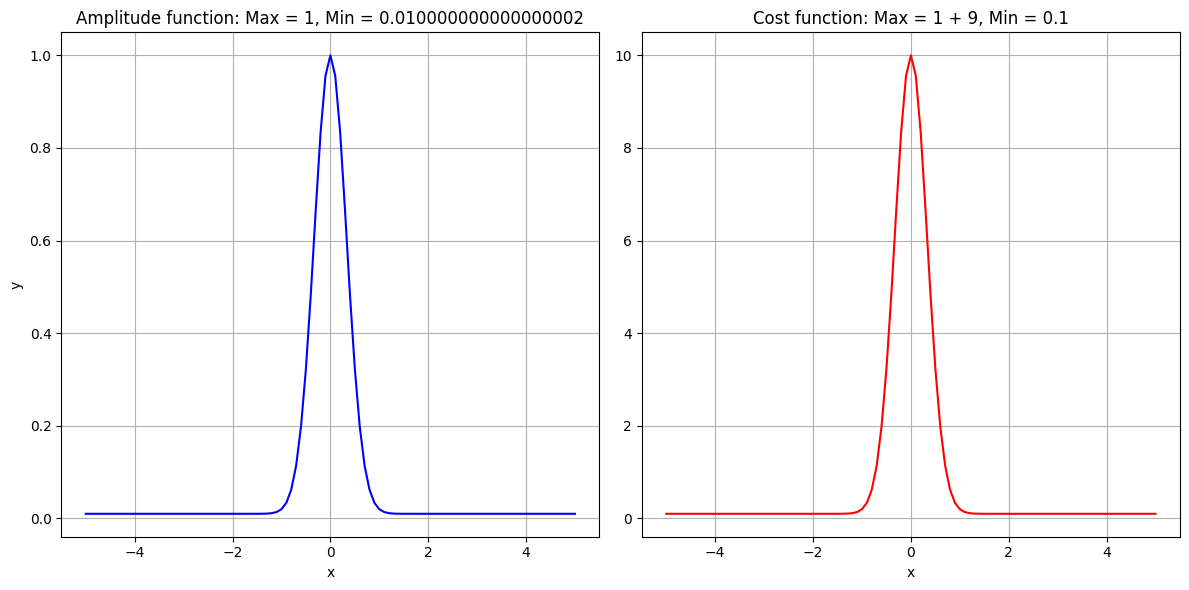

In [11]:
import matplotlib.pyplot as plt
# Define typical small values for epsilon and delta, and a moderate value for K
cost_function_epsilon = 0.1
cost_function_delta = 9
amplitude_function_width = 0.002
cost_function_width = 0.002
amplitude_function_sigma = amplitude_function_width / (2*np.sqrt(-2 * np.log(cost_function_epsilon**2)))
cost_function_sigma = cost_function_width / (2*np.sqrt(-2 * np.log(cost_function_epsilon**2)))

def amplitude_function(x):
    x_scaled = (x+500)/1000
    amplitude = torch.exp(-((x_scaled - 0.5)**2) / (2 * amplitude_function_sigma**2)) * (1 - cost_function_epsilon**2) + cost_function_epsilon**2
    return amplitude.squeeze(-1).cpu().numpy()

def cost_function(x):
    x_scaled = (x+500)/1000
    peak_height = 1 + cost_function_delta - cost_function_epsilon
    cost = torch.exp(-((x_scaled - 0.5)**2) / (2 * cost_function_sigma**2)) * peak_height + cost_function_epsilon
    return cost.squeeze(-1).cpu().numpy()

# Generate x values from 0 to 1
x_values = torch.linspace(-5, 5, 101)

# Generate y values for amplitude function and cost function
y_values_amplitude = [amplitude_function(x) for x in x_values]
y_values_cost = [cost_function(x) for x in x_values]

# Plotting the functions
plt.figure(figsize=(12, 6))

# Plot for amplitude function
plt.subplot(1, 2, 1)
plt.plot(x_values, y_values_amplitude, label="Amplitude function", color='blue')
plt.title(f"Amplitude function: Max = 1, Min = {cost_function_epsilon**2}")
plt.xlabel("x")
plt.ylabel("y")
# plt.xlim(-5,5)
plt.grid(True)

# Plot for cost function
plt.subplot(1, 2, 2)
plt.plot(x_values, y_values_cost, label="Cost function", color='red')
plt.title(f"Cost function: Max = 1 + {cost_function_delta}, Min = {cost_function_epsilon}")
plt.xlabel("x")
# plt.xlim(-5,5)
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
import csv
# Specify the header
header = ['x', 'amplitude', 'cost']

# Open a CSV file for writing
with open('eipc_example.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(header)

    # Write the data
    for data in zip(list(x_values.numpy()), y_values_amplitude, y_values_cost):
        writer.writerow(data)

### TODO
Adjust the hyperparamters to get a larger discrepancy between EIpu and Gittins

### Question
Is it necessary to pass epsilon = 0.01, delta = 9, K = 1000 as parameters to amplitude_function and cost_function?

## Define the objective function
The objective functions are constructed as sample paths drawn from the Matern kernel multiplied by the amplitude function

In [7]:
from pandora_bayesopt.utils import create_objective_function
# Create the objective model
dim = 1
nu = 2.5
lengthscale = 0.0001
outputscale = 1.0
num_rff_features = 1280
seed = 0
torch.manual_seed(seed)
matern_sample = create_objective_function(dim=dim, nu=nu, lengthscale=lengthscale, outputscale=outputscale, num_rff_features=num_rff_features)
def objective_function(x):
    return matern_sample(x) * amplitude_function(x)

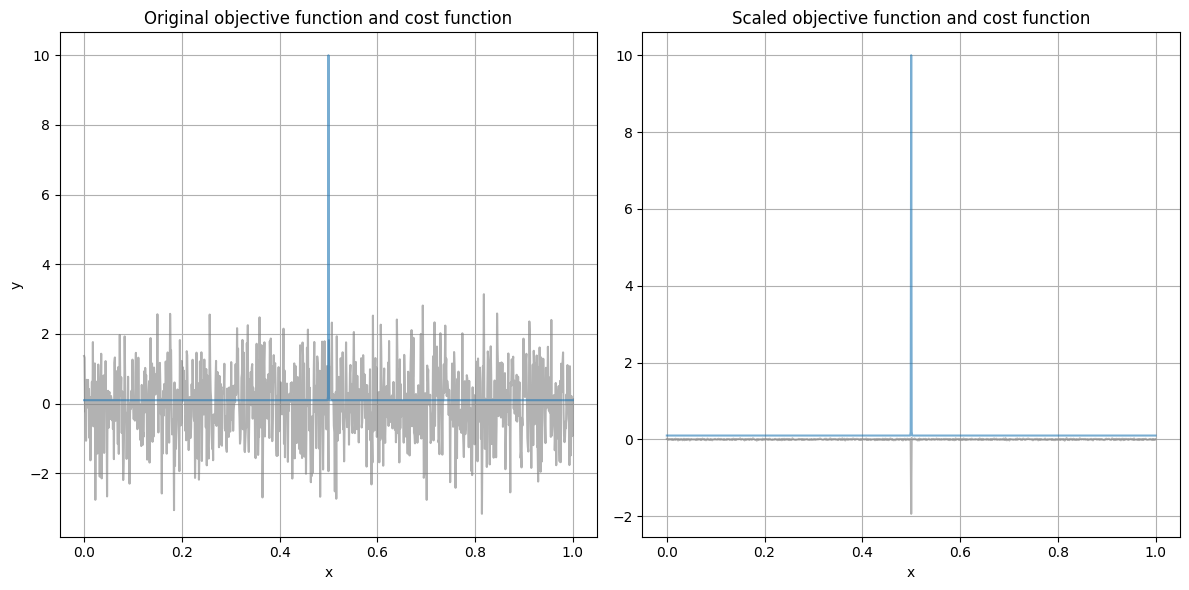

In [16]:
test_x = torch.linspace(0, 1, 1001)

# Plotting the functions
plt.figure(figsize=(12, 6))

# Plot for original objective function
plt.subplot(1, 2, 1)
plt.plot(test_x.cpu().numpy(), matern_sample(test_x.view(-1,1)).numpy(), color='tab:grey', label="Original objective function", alpha=0.6)
plt.plot(test_x.cpu().numpy(), cost_function(test_x.view(-1,1)).numpy(), label="Cost function", alpha=0.6)
plt.title(f"Original objective function and cost function")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)

# Plot for scaled objective function
plt.subplot(1, 2, 2)
plt.plot(test_x.cpu().numpy(), objective_function(test_x.view(-1,1)).numpy(), color='tab:grey', label="Scaled objective function", alpha=0.6)
plt.plot(test_x.cpu().numpy(), cost_function(test_x.view(-1,1)).numpy(), label="Cost function", alpha=0.6)
plt.title(f"Scaled objective function and cost function")
plt.xlabel("x")
plt.grid(True)

plt.tight_layout()
plt.show()

In [26]:
def plot_posterior(ax,objective_function,model,test_x,train_x,train_y):
    
    with torch.no_grad():
        
        # Plot the objective function at the test points
        ax.plot(test_x.cpu().numpy(), objective_function(test_x.view(-1,1)).numpy(), 'tab:grey', alpha=0.6)
    
        # Calculate the posterior at the test points
        posterior = model.posterior(test_x.unsqueeze(1).unsqueeze(1))

        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        lower, upper = posterior.mvn.confidence_region()
        lower = lower.squeeze(-1).squeeze(-1)
        upper = upper.squeeze(-1).squeeze(-1)
        # Plot training points as black stars
        ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*', alpha=0.8)
        # Plot posterior means as blue line
        ax.plot(test_x.cpu().numpy(), posterior.mean.squeeze(-1).squeeze(-1).cpu().numpy(), alpha=0.8)
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.2)
        
    
    ax.legend(['Objective Function', 'Observed Data', 'Mean', 'Confidence'])

### Define a customized kernel as Matern kernel with input-dependent amplitude (outputscale)

In [27]:
from gpytorch.kernels import MaternKernel
from pandora_bayesopt.kernel import VariableAmplitudeKernel

### Note
This class VariableAmplitudeKernel can be found in pandora_bayesopt.kernel

## Fit a GP model with observation data and a specified kernel

In [28]:
from pandora_bayesopt.utils import fit_gp_model

### Note
This function can be found in pandora_bayesopt.utils

In [33]:
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = lengthscale
base_kernel.raw_lengthscale.requires_grad = False
kernel = VariableAmplitudeKernel(base_kernel, amplitude_function)

### Question
Instead of setting the kernel inside fit_gp_model with given smoothness and lengthscale parameters, I set the kernel before running the BayesOPT loop so that I can also use fit_gp_model with a standard Matern kernel (base_kernel) for other tasks. However, it seems that if I only set it once, then it would be a different initial kernel when I run another policy. Not sure why this happens. To avoid such issues, I reset it before running every policy.

In [5]:
maximize = True
budget = 1+delta

In [9]:
from pandora_bayesopt.utils import find_global_optimum
global_optimum_point, global_optimum_value = find_global_optimum(objective=objective_function, dim=dim, maximize=maximize, raw_samples=10000)
print("global_optimum", global_optimum_point, global_optimum_value)
print()

/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


global_optimum tensor([0.5003]) 1.063044712529602



/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/optim/optimize.py:389: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


## Test EI policy

/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/optim/optimize.py:389: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction 

initial x: tensor([[0.]])
initial y: tensor([0.0318])
best oberved value: 0.03183152126846931
Iteration 0, measuring at x=0.4999999999999975, y=0.09503763770653884


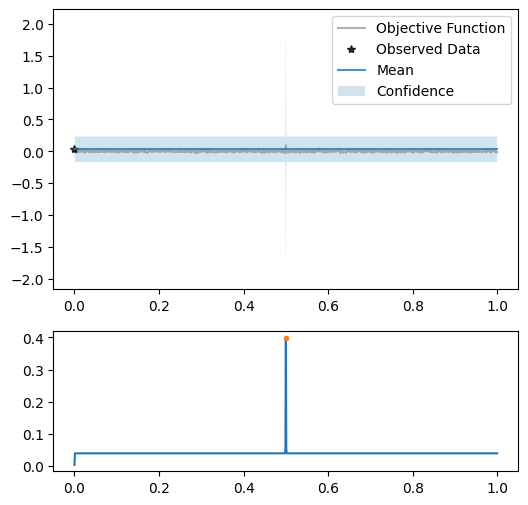

best oberved value: 0.09503763770653884
new cost: 10.0
cumulative cost: 10.0
Iteration 1, measuring at x=0.4998441503363487, y=0.18906813608398942


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0634]), std = tensor([0.0447])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


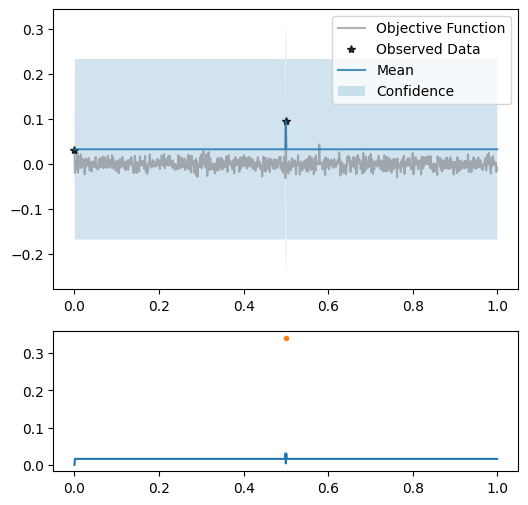

best oberved value: 0.18906813608398942
new cost: 8.952317035267757
cumulative cost: 18.952317035267757


In [32]:
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.kernels import MaternKernel

torch.manual_seed(seed)
matern_sample = create_objective_function(dim=dim, nu=nu, lengthscale=lengthscale, outputscale=outputscale, num_rff_features=num_rff_features)
def objective_function(x):
    return matern_sample(x) * amplitude_function(x)

global_optimum_point, global_optimum_value = find_global_optimum(objective=objective_function, dim=dim, maximize=maximize)

x = torch.zeros(dim).unsqueeze(0)
y = objective_function(x)
print("initial x:", x)
print("initial y:", y)
best_f = y.max().item() if maximize else y.min().item()

EI_best = [best_f] # This will store the best value
print("best oberved value:", best_f)
cumulative_cost = 0
EI_cumulative_cost_history = [0]

i = 0

while True:
    
    model = fit_gp_model(X=x, objective_X=y, kernel=kernel)
    
    # Optimize EI
    BoTorch_EI = ExpectedImprovement(model=model, best_f=best_f, maximize=maximize)
    new_point, new_point_EI = optimize_acqf(
        acq_function=BoTorch_EI,
        bounds=torch.stack([torch.zeros(dim), torch.ones(dim)]),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )
    
    # Plot the posterior and the EI
    f, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
    
    # Plot the posterior
    plot_posterior(ax1,objective_function,model,test_x,x,y)
    
    # Plot EI
    acq = BoTorch_EI.forward(test_x.unsqueeze(1).unsqueeze(1))
    ax2.plot(test_x.numpy(), acq.detach().numpy(), '-', new_point.numpy(), new_point_EI.numpy(),'.')
    
    print('Iteration {}, measuring at x={}, y={}'.format(i,new_point.item(), objective_function(new_point).item()) )
    plt.show()
    
    # Add the new data
    x = torch.cat((x,new_point))
    new_value = objective_function(new_point)
    y = torch.cat((y, new_value))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EI_best.append(best_f)
    print("best oberved value:", best_f)
    
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    EI_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

### Question
- Do I need to care about these warnings?

## Test EI per unit cost policy

/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/optim/optimize.py:389: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction 

best oberved value: 0.03183152126846931


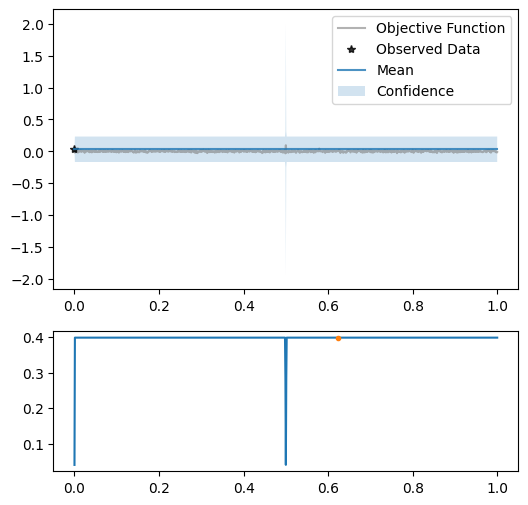

Iteration 0, measuring at x=0.622907075099647, y=0.0042421649129975
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 0.1


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0180]), std = tensor([0.0195])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


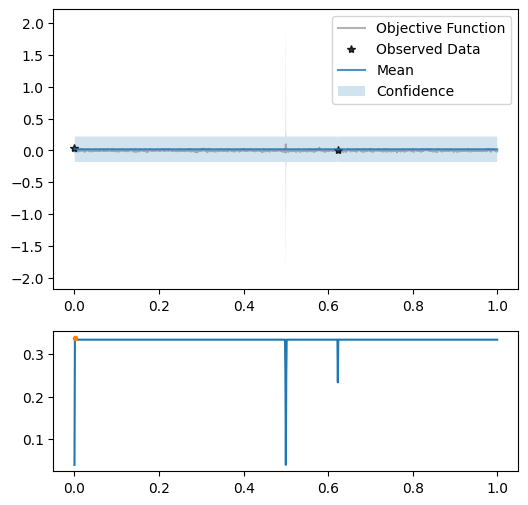

Iteration 1, measuring at x=0.00019217774381237568, y=-0.0047776486488045646
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 0.2


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0104]), std = tensor([0.0191])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


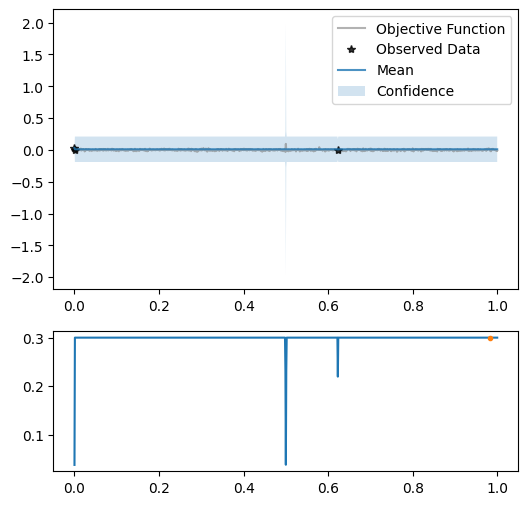

Iteration 2, measuring at x=0.9839257933199406, y=-0.01565921414361214
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 0.30000000000000004


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0039]), std = tensor([0.0203])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 3, measuring at x=0.6225501997196873, y=0.004818865082193583
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 0.4
Iteration 4, measuring at x=0.6232869685298418, y=3.565985544891182e-05
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 0.5
Iteration 5, measuring at x=0.622227669401544, y=-0.00475381670768887
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 0.6
Iteration 6, measuring at x=0.5271241767331958, y=-0.002532169492541235
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 0.7
Iteration 7, measuring at x=0.014866353943943977, y=0.009014771044013622
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 0.7999999999999999


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0041]), std = tensor([0.0176])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0034]), std = tensor([0.0158])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0022]), std = tensor([0.0148])). Please consider scaling the 

Iteration 8, measuring at x=0.014621607933611976, y=0.004645263592217431
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 0.8999999999999999


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0027]), std = tensor([0.0124])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 9, measuring at x=0.014300992230208124, y=-0.013393049645040869
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 0.9999999999999999
Iteration 10, measuring at x=0.01612032763659954, y=-0.019629422126842877
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 1.0999999999999999
Iteration 11, measuring at x=0.6242928607389331, y=-0.013373459620420997
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 1.2
Iteration 12, measuring at x=0.3685437384992838, y=0.006079399325319232
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 1.3


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0012]), std = tensor([0.0127])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0005]), std = tensor([0.0135])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0015]), std = tensor([0.0134])). Please consider scaling th

Iteration 13, measuring at x=0.36830208053699853, y=-0.008549995705013549
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 1.4000000000000001


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0015]), std = tensor([0.0127])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 14, measuring at x=0.6236119627235519, y=-0.00037778764648316483
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 1.5000000000000002
Iteration 15, measuring at x=0.36877917177599484, y=-0.004387644759728839
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 1.6000000000000003
Iteration 16, measuring at x=0.6724337665364146, y=-0.006605638813737744
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 1.7000000000000004
Iteration 17, measuring at x=0.09171185363084078, y=-0.015100869239444453
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 1.8000000000000005


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0014]), std = tensor([0.0123])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0016]), std = tensor([0.0120])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0019]), std = tensor([0.0117])). Please consider scaling t

Iteration 18, measuring at x=0.01508039816042518, y=0.020562970188773667
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 1.9000000000000006
Iteration 19, measuring at x=0.37312549632042646, y=-0.008851132705784776
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 2.0000000000000004
Iteration 20, measuring at x=0.5406151674687862, y=-0.013482268763213628
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 2.1000000000000005


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0014]), std = tensor([0.0125])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0018]), std = tensor([0.0123])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0023]), std = tensor([0.0123])). Please consider scaling t

Iteration 21, measuring at x=0.5266767802040149, y=0.0037642527690141853
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 2.2000000000000006
Iteration 22, measuring at x=0.5254974741996131, y=0.008492746203509455
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 2.3000000000000007
Iteration 23, measuring at x=0.015250846774356498, y=0.015444216914306978
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 2.400000000000001


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0020]), std = tensor([0.0121])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0016]), std = tensor([0.0120])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0009]), std = tensor([0.0122])). Please consider scaling t

Iteration 24, measuring at x=0.5264141252546182, y=-0.02418293002682683
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 2.500000000000001
Iteration 25, measuring at x=0.11183174606412649, y=0.011538306273076542
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 2.600000000000001


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0018]), std = tensor([0.0128])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0013]), std = tensor([0.0128])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 26, measuring at x=0.11162798271768448, y=0.015844519897179984
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 2.700000000000001
Iteration 27, measuring at x=0.1114366279166089, y=-0.008500242197868796
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 2.800000000000001
Iteration 28, measuring at x=0.5252755500353854, y=0.005684487412829761
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 2.9000000000000012


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0007]), std = tensor([0.0130])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0010]), std = tensor([0.0128])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0007]), std = tensor([0.0127])). Please consider scaling t

Iteration 29, measuring at x=0.5257239439002822, y=-0.01254360844508186
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 3.0000000000000013


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0011]), std = tensor([0.0126])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 30, measuring at x=0.5250271846157419, y=-0.004268124206892424
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 3.1000000000000014
Iteration 31, measuring at x=0.11292958073318005, y=0.01949266506207415
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 3.2000000000000015
Iteration 32, measuring at x=0.11310330113843661, y=0.02557248152921379
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 3.3000000000000016
Iteration 33, measuring at x=0.11205081034844082, y=0.0040289353839179885
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 3.4000000000000017


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0012]), std = tensor([0.0125])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0006]), std = tensor([0.0128])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0002]), std = tensor([0.0134])). Please consider scaling th

Iteration 34, measuring at x=0.11326688043632671, y=0.00779664634278667
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 3.5000000000000018


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0005]), std = tensor([0.0130])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 35, measuring at x=0.11274088488816386, y=0.007860947581483332
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 3.600000000000002
Iteration 36, measuring at x=0.11433357931673527, y=0.008365944343642568
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 3.700000000000002
Iteration 37, measuring at x=0.7608702750876907, y=-0.008347025540252425
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 3.800000000000002
Iteration 38, measuring at x=0.11410208683572381, y=0.01942183538338109
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 3.900000000000002


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0007]), std = tensor([0.0129])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0009]), std = tensor([0.0128])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0007]), std = tensor([0.0127])). Please consider scaling the 

Iteration 39, measuring at x=0.11392215036133105, y=-0.013488041936906663
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 4.000000000000002


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0008]), std = tensor([0.0129])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 40, measuring at x=0.11547161112822438, y=0.0031942697383037484
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 4.100000000000001
Iteration 41, measuring at x=0.11457774623537062, y=0.004133348989130233
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 4.200000000000001


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0008]), std = tensor([0.0128])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0009]), std = tensor([0.0126])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 42, measuring at x=0.11486043939089584, y=-0.010830254955892061
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 4.300000000000001


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0006]), std = tensor([0.0126])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 43, measuring at x=0.11248648579103192, y=0.0003513723761460975
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 4.4
Iteration 44, measuring at x=0.11670937389135361, y=0.004826528535925423
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 4.5
Iteration 45, measuring at x=0.11697511272213598, y=-0.0020744684845197207


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0006]), std = tensor([0.0125])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0007]), std = tensor([0.0124])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 4.6
Iteration 46, measuring at x=0.11644510791375447, y=0.0017757049395986815
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 4.699999999999999


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0007]), std = tensor([0.0122])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0007]), std = tensor([0.0121])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 47, measuring at x=0.015456993306910537, y=0.0015556669076716592
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 4.799999999999999
Iteration 48, measuring at x=0.9380380641669035, y=-0.013734641180711903
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 4.899999999999999


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0007]), std = tensor([0.0120])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0004]), std = tensor([0.0120])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 49, measuring at x=0.8576742196455598, y=-0.012328855476704353
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 4.999999999999998
Iteration 50, measuring at x=0.11613191203629085, y=0.010896345131643772
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 5.099999999999998
Iteration 51, measuring at x=0.0034702569246292114, y=0.008303719354533034
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 5.1999999999999975


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0002]), std = tensor([0.0120])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0004]), std = tensor([0.0120])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0005]), std = tensor([0.0119])). Please consider scaling the 

Iteration 52, measuring at x=0.003238424030288678, y=-0.012895727833474311
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 5.299999999999997


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0003]), std = tensor([0.0120])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 53, measuring at x=0.11591770181410771, y=-0.006872234053110885
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 5.399999999999997
Iteration 54, measuring at x=0.003694137712708712, y=0.00036196780647955055
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 5.4999999999999964
Iteration 55, measuring at x=0.005250832997262478, y=0.004236424810628529
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 5.599999999999996


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0001]), std = tensor([0.0119])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0001]), std = tensor([0.0118])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0002]), std = tensor([0.0117])). Please consider scaling the 

Iteration 56, measuring at x=0.004157050655370986, y=0.005092268828573579
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 5.699999999999996
Iteration 57, measuring at x=0.6129237273708121, y=0.0017456944461181577
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 5.799999999999995


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0003]), std = tensor([0.0116])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0003]), std = tensor([0.0115])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 58, measuring at x=0.005520543224345365, y=-0.00914826913046611
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 5.899999999999995
Iteration 59, measuring at x=0.004414838905546784, y=0.01576582466441405
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 5.999999999999995


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0002]), std = tensor([0.0115])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0004]), std = tensor([0.0116])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 60, measuring at x=0.004606540895318948, y=-0.011142651199049778
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 6.099999999999994


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0002]), std = tensor([0.0116])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 61, measuring at x=0.6126111751165726, y=0.0034502581510533576
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 6.199999999999994
Iteration 62, measuring at x=0.6132402038169363, y=0.015798396337105784
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 6.299999999999994


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0003]), std = tensor([0.0115])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0005]), std = tensor([0.0115])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 63, measuring at x=0.6123259432949774, y=0.009917477877611942
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 6.399999999999993


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0007]), std = tensor([0.0115])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 64, measuring at x=0.6134320794603914, y=-0.0024742315804689636
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 6.499999999999993


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0006]), std = tensor([0.0114])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 65, measuring at x=0.6121033249137283, y=-0.0031550993832841602
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 6.5999999999999925
Iteration 66, measuring at x=0.43158126343041653, y=-0.0037692774345091194
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 6.699999999999992
Iteration 67, measuring at x=0.3946231259033084, y=-0.009782439902924212
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 6.799999999999992


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0006]), std = tensor([0.0114])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0005]), std = tensor([0.0113])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0004]), std = tensor([0.0113])). Please consider scaling the 

Iteration 68, measuring at x=0.2373091913759693, y=0.005328862910623214
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 6.8999999999999915
Iteration 69, measuring at x=0.23705066518901796, y=-0.010591885748125262
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 6.999999999999991
Iteration 70, measuring at x=0.0049994532881283546, y=-0.011431005918785965
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 7.099999999999991


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0004]), std = tensor([0.0112])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0003]), std = tensor([0.0112])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0001]), std = tensor([0.0112])). Please consider scaling the 

Iteration 71, measuring at x=0.23756010502659908, y=0.008723729341919588
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 7.19999999999999
Iteration 72, measuring at x=0.23867997180794598, y=0.01041667293267143
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 7.29999999999999
Iteration 73, measuring at x=0.23779086664111435, y=-0.021625912924120975
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 7.39999999999999
Iteration 74, measuring at x=0.23889600148860987, y=0.0030392841856354143
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 7.499999999999989


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0002]), std = tensor([0.0112])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0004]), std = tensor([0.0112])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([7.6695e-05]), std = tensor([0.0114])). Please consider scaling 

Iteration 75, measuring at x=0.23919907343982336, y=0.0046560732010259565
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 7.599999999999989
Iteration 76, measuring at x=0.23846191542334744, y=-0.0017363787301726316
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 7.699999999999989
Iteration 77, measuring at x=0.23946312355149396, y=-0.011930069579980168
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 7.799999999999988
Iteration 78, measuring at x=0.4036869201809168, y=0.005528503704450699
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 7.899999999999988


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0002]), std = tensor([0.0112])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0002]), std = tensor([0.0112])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-2.7722e-06]), std = tensor([0.0112])). Please consider scaling

Iteration 79, measuring at x=0.40394008546304044, y=-0.0038387440223281674
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 7.999999999999988
Iteration 80, measuring at x=0.4034357140238149, y=0.007913069846549315
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 8.099999999999987
Iteration 81, measuring at x=0.2790728015825153, y=-0.0016005541534642534
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 8.199999999999987


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.8158e-05]), std = tensor([0.0111])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0001]), std = tensor([0.0110])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([9.3774e-05]), std = tensor([0.0110])). Please consider scal

Iteration 82, measuring at x=0.7045141346752644, y=0.0001874437467709678
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 8.299999999999986
Iteration 83, measuring at x=0.7060740401639366, y=-0.018312500843083737
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 8.399999999999986


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([9.4889e-05]), std = tensor([0.0109])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0001]), std = tensor([0.0110])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 84, measuring at x=0.7041520714013267, y=-0.006788958941834469
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 8.499999999999986
Iteration 85, measuring at x=0.7048693736750365, y=-0.0017860709103813613
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 8.599999999999985


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0002]), std = tensor([0.0110])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0002]), std = tensor([0.0109])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 86, measuring at x=0.12665486615145458, y=-0.01797928776664206
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 8.699999999999985
Iteration 87, measuring at x=0.4032041047568999, y=-0.00808558504270574
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 8.799999999999985
Iteration 88, measuring at x=0.6170858852565289, y=-0.004877409146676096
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 8.899999999999984
Iteration 89, measuring at x=0.11351983087961919, y=-0.009981010600994517
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 8.999999999999984


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0004]), std = tensor([0.0110])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0005]), std = tensor([0.0110])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0006]), std = tensor([0.0109])). Please consider scaling t

Iteration 90, measuring at x=0.8736669393256307, y=0.0006455563867726223
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 9.099999999999984
Iteration 91, measuring at x=0.8747600318329652, y=-0.016490957426217694
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 9.199999999999983


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0006]), std = tensor([0.0108])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0008]), std = tensor([0.0109])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration 92, measuring at x=0.8733496647939952, y=-0.004065316713556066
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 9.299999999999983
Iteration 93, measuring at x=0.8739821483955494, y=0.0028922204198952865
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 9.399999999999983
Iteration 94, measuring at x=0.9663581978529692, y=0.005053467697087822
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 9.499999999999982
Iteration 95, measuring at x=0.9676178840876372, y=0.002431680221963236
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 9.599999999999982


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0008]), std = tensor([0.0109])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0008]), std = tensor([0.0108])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0007]), std = tensor([0.0108])). Please consider scaling t

Iteration 96, measuring at x=0.9673347853747689, y=0.004979972419195008
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 9.699999999999982
Iteration 97, measuring at x=0.96610664824199, y=-0.0007316535093428507
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 9.799999999999981
Iteration 98, measuring at x=0.9666099888116632, y=0.013888005875748826
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 9.89999999999998
Iteration 99, measuring at x=0.11877397260178445, y=-0.005554759495214993
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 9.99999999999998


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0007]), std = tensor([0.0107])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0007]), std = tensor([0.0106])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0005]), std = tensor([0.0107])). Please consider scaling t

Iteration 100, measuring at x=0.9670758993008053, y=0.0007541542364868871
best oberved value: 0.03183152126846931
new cost: 0.1
cumulative cost: 10.09999999999998


In [34]:
from pandora_bayesopt.acquisition.ei_puc import ExpectedImprovementWithCost

torch.manual_seed(seed)
matern_sample = create_objective_function(dim=dim, nu=nu, lengthscale=lengthscale, outputscale=outputscale, num_rff_features=num_rff_features)
def objective_function(x):
    return matern_sample(x) * amplitude_function(x)

global_optimum_point, global_optimum_value = find_global_optimum(objective=objective_function, dim=dim, maximize=maximize)

x = torch.zeros(dim).unsqueeze(0)
y = objective_function(x)
best_f = y.max().detach().numpy() if maximize else y.min().detach().numpy()
EIpu_best = [best_f] # This will store the best value
print("best oberved value:", best_f)
cumulative_cost = 0
EIpu_cumulative_cost_history = [0]

i = 0

while True:
    
    model = fit_gp_model(X=x, objective_X=y, kernel=kernel)
    
    # Optimize EIpu
    EIpu = ExpectedImprovementWithCost(model=model, best_f=best_f, maximize=maximize, cost=cost_function)
    new_point, new_point_EIpu = optimize_acqf(
        acq_function=EIpu,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64, device=device),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )

    if i < 3:
    
        # Plot the posterior and the EIpu
        f, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})
        
        # Plot the posterior
        plot_posterior(ax1,objective_function,model,test_x,x,y)
        
        # Plot EIpu
        acq = EIpu.forward(test_x.unsqueeze(1).unsqueeze(1))
        ax2.plot(test_x.numpy(), acq.detach().numpy(), '-', new_point.numpy(), new_point_EIpu.numpy(),'.')
        
        plt.show()

    print('Iteration {}, measuring at x={}, y={}'.format(i,new_point.item(), objective_function(new_point).item()) )
    
    # Add the new data
    x = torch.cat((x,new_point))
    new_value = objective_function(new_point)
    y = torch.cat((y, new_value))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EIpu_best.append(best_f)
    print("best oberved value:", best_f)
    
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    EIpu_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

## Test Gittins policy with a small constant lambda

/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0318]), std = tensor([nan])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


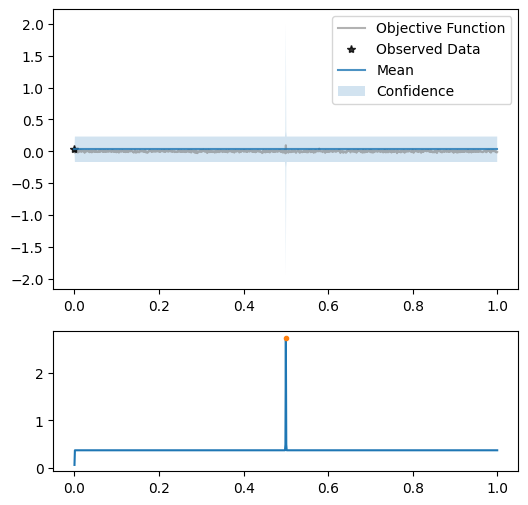

Iteration: 0
best oberved value: 0.03183152126846931
new point: [[0.5]]
new value: 0.09504823964639916
new acq: 2.7496370364894043

new cost: 9.999999999910331
cumulative cost: 9.999999999910331


/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0634]), std = tensor([0.0447])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


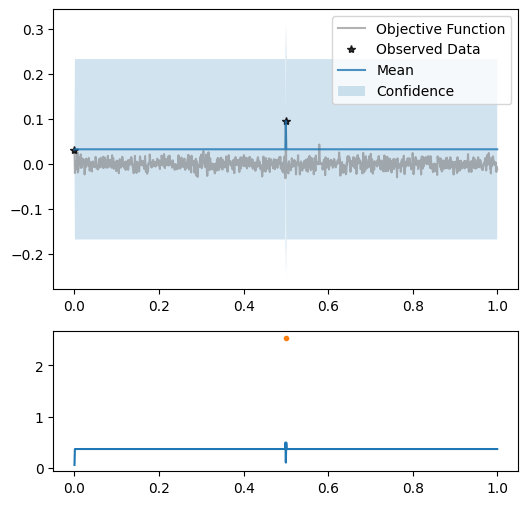

Iteration: 1
best oberved value: 0.09504823964639916
new point: [[0.50016989]]
new value: 0.21968891818448927
new acq: 2.541990621594697

new cost: 8.767782913241481
cumulative cost: 18.767782913151812


In [35]:
from pandora_bayesopt.acquisition.gittins import GittinsIndex
x = torch.zeros(dim).unsqueeze(0)
y = objective_function(x)
best_f = y.max().detach().numpy() if maximize else y.min().detach().numpy()

GIlmbda_best = [best_f] # This will store the best value
cumulative_cost = 0
GIlmbda_cumulative_cost_history = [0]

i = 0

while True:
    
    model = fit_gp_model(X=x, objective_X=y, kernel=kernel)
    
    # Optimize Gittins
    GIlmbda = GittinsIndex(model=model, lmbda=0.0001, maximize=maximize, cost=cost_function)
    new_point, new_point_GIlmbda = optimize_acqf(
        acq_function=GIlmbda,
        bounds=torch.tensor([[0.0], [1.0]], dtype=torch.float64),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={'method': 'L-BFGS-B'},
    )

    new_value = objective_function(new_point)

    # Plot the posterior and the Gittins
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2, 1]})

    # Plot the posterior
    plot_posterior(ax1, objective_function, model, test_x, x, y)

    # Plot Gittins
    GIlmbda_acq = GIlmbda.forward(test_x.unsqueeze(1).unsqueeze(1))
    ax2.plot(test_x.numpy(), GIlmbda_acq.detach().numpy(), '-', new_point.item(), new_point_GIlmbda.item(), '.')
    plt.show()

    print("Iteration:", i)
    print("best oberved value:", best_f)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())
    print("new acq:", new_point_GIlmbda.item())
    print()

    # Add the new data
    x = torch.cat((x, new_point))
    y = torch.cat((y, new_value))

    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
    GIlmbda_best.append(best_f)
        
    cumulative_cost += cost_function(new_point).item()
    print("new cost:", cost_function(new_point).item())
    print("cumulative cost:", cumulative_cost)
    GIlmbda_cumulative_cost_history.append(cumulative_cost)
    
    if cumulative_cost > budget:
        break
    
    i = i + 1

## Plot best observed vs cumulative cost until the budget=1+delta

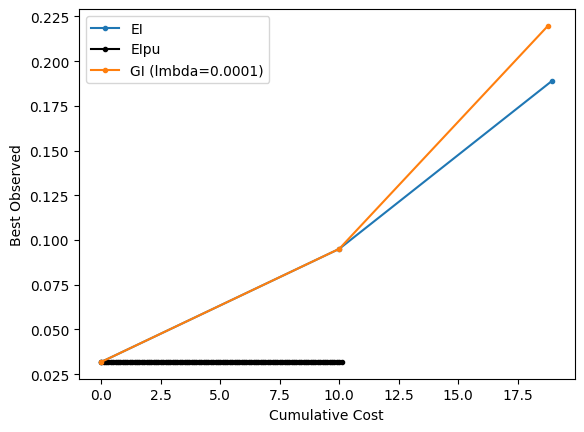

In [36]:
plt.plot(EI_cumulative_cost_history, EI_best, '.-', label="EI")
plt.plot(EIpu_cumulative_cost_history, EIpu_best, '.-', label="EIpu", color='black')
plt.plot(GIlmbda_cumulative_cost_history, GIlmbda_best, '.-', label="GI (lmbda=0.0001)")
plt.xlabel('Cumulative Cost')
plt.ylabel('Best Observed')
plt.legend()

### Question
- Shall we caculate the average regret rather than the average best observed value across different instances?

- Shall we set a larger budget?

### TODO
- A sweep with different smoothness, lengthscales and seeds